In [16]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

In [17]:
import os
import pandas as pd
import tensorflow as tf
import google.datalab.bigquery as dlbq

In [18]:
tf.test.is_built_with_cuda()

False

In [19]:
tf.logging.set_verbosity(tf.logging.INFO)

---
##### From Jupyter notebook to python package
From exploration to production.

This little tool dumps a given function to a file with the same name in a certain package

In [20]:
PACKAGE="./train"
from tools import make_src_dumper
write_py = make_src_dumper(PACKAGE)

---
# Prediction 


#### Signature data for testing

First, let's get some test data. Now we need signature data, and that's what we have in Bigquery. Remember? 

In [21]:
from train.model_config import SIGNATURE_FLOAT_COLUMNS
from train.model_config import SIGNATURE_INT_COLUMNS
from train.model_config import SIGNATURE_STR_COLUMNS
from signature_queries import sample_query

SIGNATURE_COLUMNS = SIGNATURE_FLOAT_COLUMNS+SIGNATURE_INT_COLUMNS+SIGNATURE_STR_COLUMNS
signature_query=sample_query(SIGNATURE_COLUMNS, total=1000)
print(signature_query)
sample = dlbq.Query(signature_query).execute().result().to_dataframe()
print('Only {} examples. Showing first three:'.format(len(sample)))
sample[:3]


    SELECT
        DEP_LAT, DEP_LON, DEP_DELAY, MEAN_TEMP_DEP, MEAN_VIS_DEP, WND_SPD_DEP, ARR_LAT, ARR_LON, ARR_DELAY, MEAN_TEMP_ARR, MEAN_VIS_ARR, WND_SPD_ARR, DEP_DOW, DEP_T, ARR, AIRLINE
    FROM 
        `going-tfx.examples.ATL_JUNE_SIGNATURE` 
    where
        MOD(ABS(FARM_FINGERPRINT(
            CONCAT(DATE,AIRLINE,ARR)
        )) + DEP_T, 1000) >= 0 
    and
        MOD(ABS(FARM_FINGERPRINT(
            CONCAT( DATE, AIRLINE, ARR)
        )) + DEP_T, 1000) < 1 
    
Only 304 examples. Showing first three:


,DEP_LAT,DEP_LON,DEP_DELAY,MEAN_TEMP_DEP,MEAN_VIS_DEP,WND_SPD_DEP,ARR_LAT,ARR_LON,ARR_DELAY,MEAN_TEMP_ARR,MEAN_VIS_ARR,WND_SPD_ARR,DEP_DOW,DEP_T,ARR,AIRLINE
0,33.63,-84.42,45.0,75.6,7.4,4.2,27.77,-97.5,41.0,82.2,9.5,10.5,1,2032,CRP,EV
1,33.63,-84.42,0.0,78.0,8.1,6.0,27.77,-97.5,-7.0,83.2,9.8,5.8,7,1807,CRP,EV
2,33.63,-84.42,61.0,84.2,9.8,5.2,27.77,-97.5,63.0,82.9,9.5,7.6,5,1838,CRP,EV


In [22]:
import json
samplefile='/tmp/test.json'
a_record = sample.to_dict(orient='records')[0]
a_record.pop('ARR_DELAY')
with open(samplefile, 'w') as f:
    f.write(json.dumps(a_record))
!cat $samplefile

{"WND_SPD_DEP": 4.2, "DEP_DELAY": 45.0, "ARR_LAT": 27.77, "WND_SPD_ARR": 10.5, "MEAN_VIS_DEP": 7.4, "DEP_T": 2032, "MEAN_TEMP_ARR": 82.2, "DEP_LON": -84.42, "DEP_DOW": 1, "MEAN_VIS_ARR": 9.5, "ARR": "CRP", "AIRLINE": "EV", "MEAN_TEMP_DEP": 75.6, "DEP_LAT": 33.63, "ARR_LON": -97.5}

---
#### Local prediction with gcloud ml-engine

In [23]:
DATASET='samples'
model_dir='gs://going-tfx/%s/model' % DATASET
all_versions = !gsutil ls $model_dir/export/exporter
all_versions[1:]

['gs://going-tfx/samples/model/export/exporter/1543067788/',
 'gs://going-tfx/samples/model/export/exporter/1543067886/',
 'gs://going-tfx/samples/model/export/exporter/1543067985/',
 'gs://going-tfx/samples/model/export/exporter/1543068083/',
 'gs://going-tfx/samples/model/export/exporter/1543068182/']

Choose your version from the above

In [24]:
latest_model=!gsutil ls gs://going-tfx/$DATASET/model/export/exporter | sort | tail -1
latest_model = latest_model[0]
latest_model

'gs://going-tfx/samples/model/export/exporter/1543068182/'

In [25]:
!gcloud ml-engine local predict \
  --model-dir=$latest_model \
  --json-instances=/tmp/test.json


OUTPUT
[28.788394927978516]


In [26]:
import json
samplefile='/tmp/test.json'
records = sample.to_dict(orient='records')[:20]
with open(samplefile, 'w') as f:
    for record in records:
        record.pop('ARR_DELAY')
        f.write(json.dumps(record))
        f.write('\n')
!cat $samplefile | tail -2

{"WND_SPD_DEP": 5.8, "DEP_DELAY": 7.0, "ARR_LAT": 33.56, "WND_SPD_ARR": 3.6, "MEAN_VIS_DEP": 8.7, "DEP_T": 1930, "MEAN_TEMP_ARR": 79.3, "DEP_LON": -84.42, "DEP_DOW": 7, "MEAN_VIS_ARR": 8.8, "ARR": "BHM", "AIRLINE": "DL", "MEAN_TEMP_DEP": 80.8, "DEP_LAT": 33.63, "ARR_LON": -86.75}
{"WND_SPD_DEP": 6.2, "DEP_DELAY": 4.0, "ARR_LAT": 42.36, "WND_SPD_ARR": 6.9, "MEAN_VIS_DEP": 9.9, "DEP_T": 2135, "MEAN_TEMP_ARR": 63.3, "DEP_LON": -84.42, "DEP_DOW": 2, "MEAN_VIS_ARR": 6.3, "ARR": "BOS", "AIRLINE": "DL", "MEAN_TEMP_DEP": 73.1, "DEP_LAT": 33.63, "ARR_LON": -71.0}


---
#### Predicting from within python code

In [27]:
estimator = tf.contrib.predictor.from_saved_model(latest_model)

INFO:tensorflow:Restoring parameters from gs://going-tfx/samples/model/export/exporter/1543068182/variables/variables


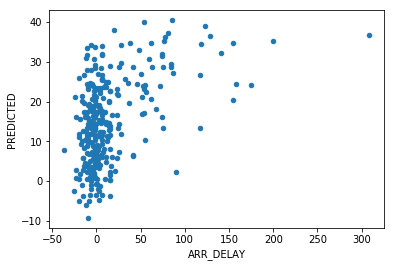

In [28]:
%matplotlib inline
compare=sample.copy()
predicted = estimator(sample.to_dict(orient='list'))
compare['PREDICTED'] = predicted['output']
compare.plot.scatter(x='ARR_DELAY', y='PREDICTED')